# Исследование возможности библиотеки Pyro по оптимизации временного ряда, генерируемого пуассоновским распределением

## Постановка задачи

Имеется временной ряд
$$T=\{T_i\}, T_i \sim Poisson(\lambda_i)$$

Значение $\lambda_i$ ищем из параметрического семейства (здесь: линейные функции)

Задача: по имеющейся реализации ряда $T$ найти значения параметров линейной функции.

Для решения используем стохастический вариационный вывод из библиотеки pyro. 

Нужно написать две функции:

model: функция, генерящая по парамерам линейной функции сэмпл временного ряда (который мы будем приближать к фактическому)

guide: функция, генерящая параметры линейной функции из какого-то распределения, которое мы тоже будем оптимизировать. В данном случае оно будет нормальным с оптимизируемыми $\mu$ и $\sigma$


In [1]:
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import seaborn as sns
from scipy.stats import poisson
from torch.distributions import constraints
import pyro.optim as optim
import torch
import pyro
import pyro.distributions as dist
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pyro.infer import Predictive
import plotly.graph_objects as go

## Подготовка данных

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='fact'>)

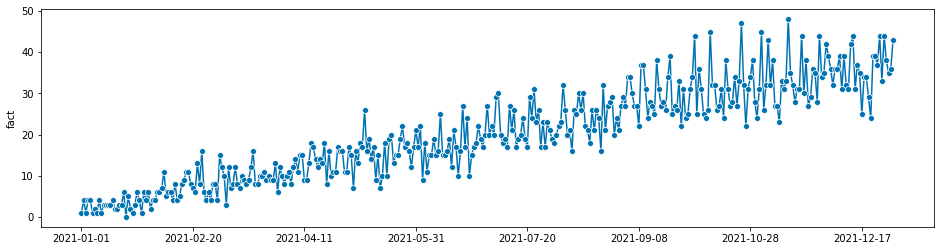

In [2]:
t = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2021-01", periods=365, freq="D")), is_relative=False
)
cutoff = pd.Period("2021-01-01", freq="D")
fact_coef = 0.1
fact_intercept = 2
l = t.to_relative(cutoff=cutoff).to_numpy()* fact_coef + fact_intercept
df = pd.DataFrame(index=t)
df['lambda'] = l
df['fact'] = poisson.rvs(l)
plot_series(df['fact'])

## Решаем задачу методом максимизации правдоподобия

In [3]:
# Функция (анти)правдоподобия, сравнивающее факт с заданным коэффициентами распределением
# Вводим знак минус, чтобы сформулировать задачу минимизации, а не максимизации
def loglikelihood(params, fact):
    k,b=params
    l = t.to_relative(cutoff=cutoff).to_numpy()*k+b
    p = poisson.pmf(fact,l)
    return -np.sum(np.log(p))

In [4]:
loglikelihood ((0,2),df['fact'])

12465.598218748379

In [5]:
loglikelihood((fact_coef,fact_intercept),df['fact'])

1017.822579331583

Данное значение мы хотим получить с помощью оптимизации

In [6]:
from scipy.optimize import minimize

minimize(loglikelihood, 
         np.array([1,1]), 
         args=(df['fact'],), 
         bounds=[
             (0, 10),
             (0.1,10)
         ],
         method='L-BFGS-B')

      fun: 1017.7138905234387
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.2837055 , -0.00171667])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 22
     njev: 28
   status: 0
  success: True
        x: array([0.10004067, 1.9103196 ])

Итог: Коэффициент приблизился довольно точно, сдвиг --- с ошибкой, но он действительно мало на что влияет в таком ряду

## Использование Pyro SVI

In [7]:
# Наша ось абсцисс в формате torch.tensor
tx = torch.tensor(t.to_relative(cutoff=cutoff).to_numpy())

In [38]:
def model(X):
    # Априорное распределение на коэффициенты (при работе SVI коэффициенты будут браться из guide)
    k = pyro.sample("k", dist.Uniform(torch.tensor(0.0), torch.tensor(10.0))) 
    b = pyro.sample("b", dist.Uniform(torch.tensor(0.0), torch.tensor(10.0))) 
    
    # Собственно, модель
    l = tx*k+b
    
    # Сэмплирование ряда по модели
    with pyro.plate("observed_data", size=len(l)):
        sample = pyro.sample("poisson_data", dist.Poisson(l), obs=X)
    return 

In [31]:
def guide(X):
    
    # Инициализация априорных параметров распределений на коэффициенты модели
    k_loc = torch.tensor((1)) 
    # note that we initialize the scale to be pretty narrow
    k_scale = torch.tensor(0.001)
    b_loc = torch.tensor((1)) 
    b_scale = torch.tensor(0.001)

    guide_k_mean = pyro.param("guide_k_mean", k_loc, constraint=constraints.positive)
    guide_k_scale = pyro.param("guide_k_scale", k_scale, constraint=constraints.positive)
    guide_b_mean = pyro.param("guide_b_mean", b_loc, constraint=constraints.positive)
    guide_b_scale = pyro.param("guide_b_scale", b_scale, constraint=constraints.positive)

    # Сэмплирование коэффициентов модели (имена должны совпадать здесь и в model)
    k = pyro.sample("k", dist.Normal(guide_k_mean, guide_k_scale)) 
    b = pyro.sample("b", dist.Normal(guide_b_mean, guide_b_scale)) 
    

In [32]:
# Все параметры оптимизируются и хранятся в param_store, очищаем его для опимизации с нуля
pyro.clear_param_store()

# Движок оптимизации
adam_params = {"lr": 0.002, "betas": (0.95, 0.999)}
optimizer = optim.Adam(adam_params)
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

In [33]:
losses = []

### Фактический ряд в формате torch.tensor
X_ = torch.tensor(df['fact']).reshape((1,-1))

### training / inference
for t in range(10000):
    ### svi.step takes same parameters as inpust as our defined model(X) and guide(X) function
    loss = svi.step(X_)
    losses.append(loss)
    ### for monitoring
    if t%1000==0:
        print (t, "\t", loss)

0 	 44242.291486263275
1000 	 5176.5646587610245
2000 	 1428.8486413955688
3000 	 1089.193143606186
4000 	 1058.094781279564
5000 	 1035.3503128290176
6000 	 1028.5458114147186
7000 	 1028.691620707512
8000 	 1028.8311874866486
9000 	 1028.682025551796


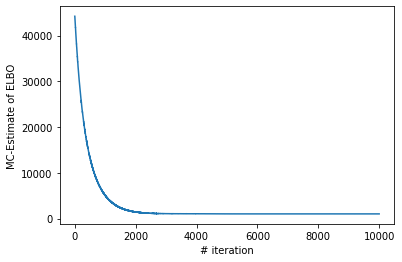

In [35]:
plt.xlabel("# iteration")
plt.ylabel("MC-Estimate of ELBO")
plt.plot(range(len(losses)), losses)

In [36]:
for name in pyro.get_param_store().get_all_param_names():
    print(name, pyro.param(name).data.numpy())

guide_k_mean 0.09986738
guide_k_scale 0.0012055798
guide_b_mean 1.9035867
guide_b_scale 0.17764762


Получили распределения коэффициентов модели (берём интервал $\mu \pm 3 \sigma$):

$$k=0.1 \pm 0.004$$
$$b=1.9 \pm 0.5$$

    
    

### Построение интервалов для поиска аномалий

По распределениям коэффициентов модели мы генерим 1000 возможных реализаций нашего ряда и строим ежедневные 1% и 99% квантили

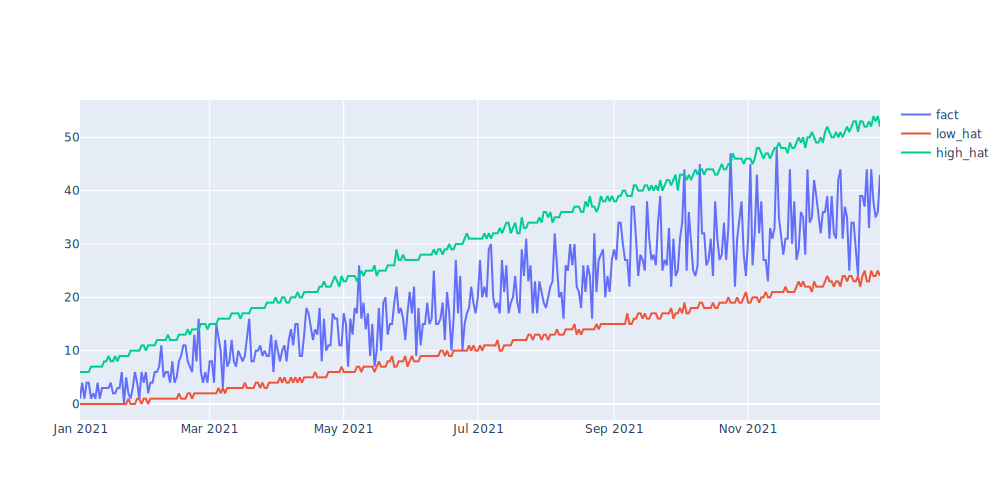

In [40]:
pred = Predictive(model,guide=guide, num_samples=1000)
result = pred(None)
samples = result['poisson_data'].numpy()
quantiles = np.quantile(samples, (0.01,0.99), axis=0)
df['low_hat'] = quantiles[0]
df['high_hat'] = quantiles[1]


fig = go.Figure(layout=dict(width=1000))
fig.add_trace(go.Scatter(
    x=df.index.strftime('%Y-%m-%d'), y=df.fact, name='fact'
))

fig.add_trace(go.Scatter(
    x=df.index.strftime('%Y-%m-%d'), y=df.low_hat, name='low_hat'
))

fig.add_trace(go.Scatter(
    x=df.index.strftime('%Y-%m-%d'), y=df.high_hat, name='high_hat'
))
fig.show(renderer='svg')



Видим, что за 1% квантили даже без аномалий иногда ряд выходит (в 1% случаев, ага)